In [56]:
import numpy as np
from sklearn import neighbors
from sklearn import metrics

In [57]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [58]:
datapath = '/media/sf_VBox_Shared/timeseries/PAMAP2_Dataset/slidingwindow512cleaned/'

In [59]:
X_train = np.load(datapath+'X_train.npy')
y_train_binary = np.load(datapath+'y_train_binary.npy')
X_val = np.load(datapath+'X_val.npy')
y_val_binary = np.load(datapath+'y_val_binary.npy')
X_test = np.load(datapath+'X_test.npy')
y_test_binary = np.load(datapath+'y_test_binary.npy')

In [60]:
print(X_train.shape)
print(X_val.shape)

(12497, 512, 9)
(2007, 512, 9)


In [61]:
def transform_dataset(X):
    num_samples, num_timesteps, num_channels = X.shape
    return X.reshape(num_samples, num_timesteps*num_channels)

In [62]:
n_neighbors = 1

In [63]:
clf = neighbors.KNeighborsClassifier(n_neighbors)

In [64]:
n_samples = 1000
clf.fit(transform_dataset(X_train[:n_samples,:]), y_train_binary[:n_samples])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [65]:
val_predict = clf.predict(transform_dataset(X_val))

In [66]:
print(metrics.confusion_matrix(np.where(val_predict)[1], np.where(y_val_binary)[1]))

[[231   0   0   0   0   0   0   0   0   0   0]
 [  0  98   0   3   0   0 211  84   0   0  67]
 [  0   0 233 160   0   0  37  39  67 115   2]
 [  0   0   0 145   0   0   2   1   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   3   0   0   0   4   0]
 [  0   0   0   5   0   0  13   0   0   0   0]
 [  0   0   0   0   0   0   0   3   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  17   0]
 [  0   0   0   0  11 199   0   0   0  55 201]]


In [67]:
metrics.accuracy_score(val_predict, y_val_binary)

0.47085201793721976

In [62]:
X_trainval = np.append(X_train, X_val, axis=0)
y_trainval = np.append(y_train_binary, y_val_binary, axis=0)
print(X_trainval.shape)

(24994, 512, 9)


In [ ]:
#On test set
clf2 = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(transform_dataset(X_trainval), y_trainval)
test_predict = clf.predict(transform_dataset(X_test))
metrics.accuracy_score(test_predict, y_test_binary)

## DTW

In [59]:
from dtw import dtw
from fastdtw import fastdtw


In [50]:
dist = lambda a, b: norm(a - b, ord=2)
#print(dist(2,4))
a1 = np.ones((2,1))
a0 = np.zeros((2,1))
print(dist(a0,a1))
dtw_func = lambda x,y: dtw(x, y, dist=dist)[0]
print(dtw_func(a0,a1)

1.41421356237
0.5


In [61]:
fastdtw_func = lambda x,y: fastdtw(x, y, dist=dist)[0]

In [ ]:
# This predicts for all validation samples - but it's very slow!
pred = np.zeros_like(y_val_binary)
num_train = 10 #X_train.shape[0]
for i in range(10): #range(X_val.shape[0]):
    x = X_val[i,:,:]
    distances = [dtw_func(x, X_train[j,:,:]) for j in range(num_train)]
    print(i)
    print(distances)
    minind = np.argmin(distances)
    pred[i,:] = y_train_binary[minind,:]

Let's see how slow this is

In [58]:
%%timeit
dtw_func(X_val[0,:,:], X_train[0,:,:])

1 loop, best of 3: 555 ms per loop


In [62]:
%%timeit
fastdtw_func(X_val[0,:,:], X_train[0,:,:])

10 loops, best of 3: 55.5 ms per loop


## Random forest

In [72]:
from sklearn import ensemble

In [73]:
random_forest = ensemble.RandomForestClassifier(n_estimators=500, verbose=1)

In [74]:
n_samples = 1000
random_forest.fit(transform_dataset(X_train[:n_samples, :]), y_train_binary[:n_samples])

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   26.3s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   29.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [75]:
val_predict_rf = random_forest.predict(transform_dataset(X_val))

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.9s finished


In [76]:
metrics.accuracy_score(val_predict_rf, y_val_binary)

0.60986547085201792

In [77]:
maj_class = y_val_binary.sum(axis=0).argmax()
print('majority class:', maj_class,  y_val_binary.mean(axis=0)[maj_class])

majority class: 3 0.155954160438


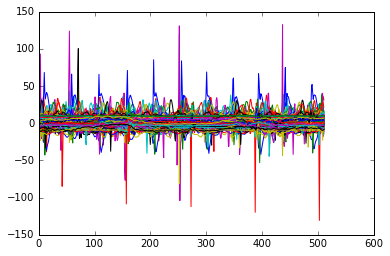

In [78]:
for i in range(479, 500):
    plt.plot(X_train[i,:,:])